### 优化思路
1）一共有40个品牌，求和price之间的统计特征，包括：mean，std,max，min
查看对于构造的品牌特征，是否对MAE有帮助
2）考虑其他的字段，也采用target_encoding. 
brand,bodyType,fuelType,gearbox ,kilometer,notRepairedDamage ,seller

### Score=486，使用XGBoost,n_estimators=30000,learning_rate=0.005
### 后续优化方向：
* 还可以使用LightGBM，CatBoost
* 还可以将多个模型进行融合，比如XGBoost+LightGBM+CatBoost
* 尝试下Nerual Network
* 继续特征工程,将brand,bodyType,fuelType,gearbox ,kilometer,notRepairedDamage ,seller与Price进行特征交叉
* 还可以与其他参数进行特征交叉


In [135]:
for col in X_data.columns:
    num=X_data[col].nunique()
    if num>40:
        print(col,num)
        

model 248
power 566
regionCode 7905
v_0 143997
v_1 143998
v_2 143997
v_3 143998
v_4 143998
v_5 139624
v_6 109766
v_7 138709
v_8 142451
v_9 140617
v_10 143997
v_11 143997
v_12 143997
v_13 143998
v_14 143998
regDate_diff 3597
creatDate_diff 96
creatDate-regDate 9052


### 思考逻辑：除了brand,还有哪些其他特征可以挖掘
* 特征的唯一值个数,应该少一点，如果很多，比如有15万(不太好)，或者10个(更好)会造成特征泄露，不稳定
* target_encoding,将col与target进行交叉特征

In [7]:
X_data['brand'].value_counts()
print(len(X_data['brand'].value_counts())) #品牌一共有40个

40


F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='brand', ylabel='price'>

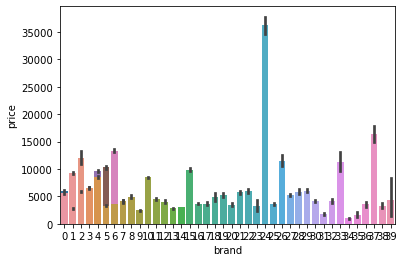

In [5]:
import seaborn as sns
sns.barplot(X_data['bodyType'],Y_data)
sns.barplot(X_data['brand'],Y_data) #黑色线是误差棒，代表误差区间

In [4]:
X_data.columns

Index(['name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller',
       'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7',
       'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')

In [114]:
import pandas as pd
import pickle
with open('./X_data.pkl','rb') as file:
    X_data=pickle.load(file)
with open('./Y_data.pkl','rb') as file:
    Y_data=pickle.load(file)
with open('./X_test.pkl','rb') as file:
    X_test=pickle.load(file)

In [2]:
X_data[['regDate','creatDate']]

,regDate,creatDate
0,20040402,20160404
1,20030301,20160309
2,20040403,20160402
3,19960908,20160312
4,20120103,20160313
...,...,...
149995,20000607,20160327
149996,20091102,20160312
149997,20101003,20160328
149998,20060312,20160401


In [115]:
# 对日期格式进行清洗
def f(x):
    x=str(x)
    if x[4:6]=='00':#对于异常值进行处理，month==00
        return x[0:4]+'-'+'01'+'-'+x[6:8]
    else:
        return x[0:4]+'-'+x[4:6]+'-'+x[6:8]
#利用pd.to_datetime转换为日期格式，方便后续进行日期的处理    
X_data['regDate']=pd.to_datetime(X_data['regDate'].apply(f)) #这里apply运用了一个自己写的函数，来调整时间格式
X_data['creatDate']=pd.to_datetime(X_data['creatDate'].apply(f))
X_data[['regDate','creatDate']]        

,regDate,creatDate
0,2004-04-02,2016-04-04
1,2003-03-01,2016-03-09
2,2004-04-03,2016-04-02
3,1996-09-08,2016-03-12
4,2012-01-03,2016-03-13
...,...,...
149995,2000-06-07,2016-03-27
149996,2009-11-02,2016-03-12
149997,2010-10-03,2016-03-28
149998,2006-03-12,2016-04-01


In [116]:
# 既要对X_train进行特征处理，对X_test数据也要处理一下
X_test['regDate']=pd.to_datetime(X_test['regDate'].apply(f)) #这里apply运用了一个自己写的函数，来调整时间格式
X_test['creatDate']=pd.to_datetime(X_test['creatDate'].apply(f))

In [117]:
#提取时间diff
#1991-01-01
X_data['regDate'].min()
X_test['regDate'].min()
base_date=pd.to_datetime('1991-01-01')
X_data['regDate_diff']=(X_data['regDate']-base_date).dt.days #间隔的天数
X_test['regDate_diff']=(X_test['regDate']-base_date).dt.days

In [118]:
#提取时间diff
#1991-01-01
X_data['creatDate'].min()
X_test['creatDate'].min()
base_date=pd.to_datetime('2014-03-10')# 这里应该找训练集，测试集中最小的数据

X_data['creatDate_diff']=(X_data['creatDate']-base_date).dt.days #间隔的天数
X_test['creatDate_diff']=(X_test['creatDate']-base_date).dt.days


In [119]:
#构造新特征'creatDate-regDate
X_data['creatDate-regDate']=(X_data['creatDate']-X_data['regDate']).dt.days #注意（）括号
X_test['creatDate-regDate']=(X_test['creatDate']-X_test['regDate']).dt.days #注意（）括号

In [120]:
#去掉原始的日期类型
X_data.drop(['regDate','creatDate'],axis=1,inplace=True)
X_test.drop(['regDate','creatDate'],axis=1,inplace=True)


In [27]:
#优化思路
#1）一共有40个品牌，求和price之间的统计特征，包括：mean，std,max，min
#一共有40个品牌
len(X_data['brand'].value_counts())

40

In [121]:
#target_encoding 可以考虑的字段：brand,bodyType,fuelType,gearbox ,kilometer,notRepairedDamage ,seller 
target_encoding=[]
for col in X_data.columns:
    num=X_data[col].nunique()
    if num<=40:
        print(col,num)
        target_encoding.append(col)

brand 40
bodyType 8
fuelType 7
gearbox 2
kilometer 13
notRepairedDamage 2
seller 2


F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


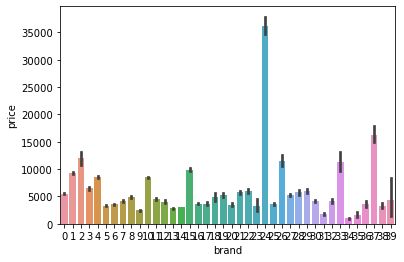

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


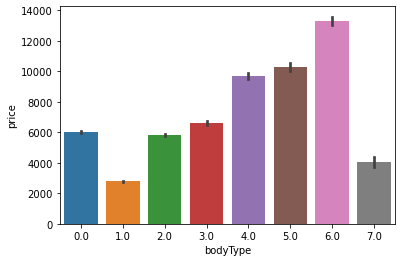

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


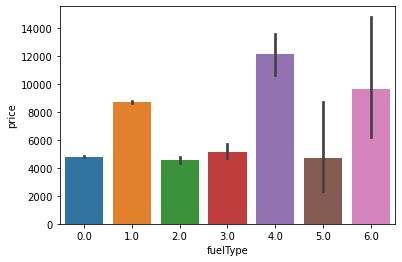

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


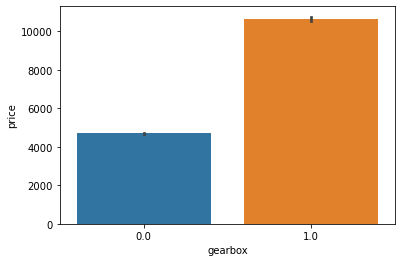

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


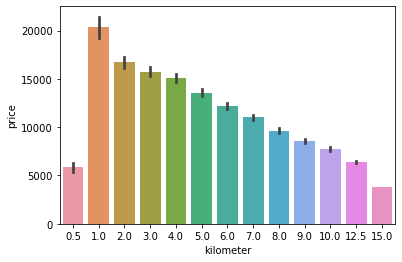

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


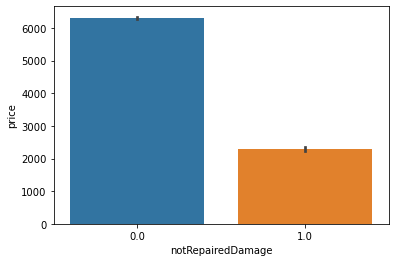

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


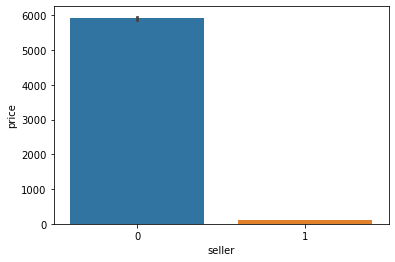

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
for col in target_encoding:
    sns.barplot(X_data[col],Y_data)
    plt.show()

In [122]:
#将X_data和Y_data进行拼接
data=pd.merge(X_data,Y_data,left_index=True,right_index=True)
data

,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,...,v_9,v_10,v_11,v_12,v_13,v_14,regDate_diff,creatDate_diff,creatDate-regDate,price
0,736,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,...,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,4840,756,4385,1850
1,2262,40.0,1,2.0,0.0,0.0,0,15.0,0.0,4366,...,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,4442,730,4757,3600
2,14874,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,...,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,4841,754,4382,6222
3,71865,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,...,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,2077,733,7125,2400
4,111080,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,...,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,7672,734,1531,5200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,163978,121.0,10,4.0,0.0,1.0,163,15.0,0.0,4576,...,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592,3445,748,5772,5900
149996,184535,116.0,11,0.0,0.0,0.0,125,10.0,0.0,2826,...,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160,6880,733,2322,9500
149997,147587,60.0,11,1.0,1.0,0.0,90,6.0,0.0,3302,...,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931,7215,749,2003,7500
149998,45907,34.0,10,3.0,1.0,0.0,156,15.0,0.0,1877,...,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014,5549,753,3673,4999


In [ ]:
##前提：我们选择的分类特征，他们的唯一值都不多，为了避免标签泄露（过拟合）

In [123]:
#将target_encoding字段，与price构造交叉特征，比如构造brand_price_mean,brand_price_min,brand_price_max,std,median
def construct_features(col):
    #构造新特征
    temp_data=data.groupby(col)['price'].agg(['min','max','mean','std','median','count']).reset_index() #这个reset_index()有点东西
    temp_data.columns=[col,col+'_min',col+'_max',col+'_mean',col+'_std',col+'_median',col+'_count'] #第一列多了一个brand
    #拼接到大表中
    return pd.merge(X_data,temp_data,on=col, how='left')

for col in target_encoding:
    X_data=construct_features(col)
X_data

,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,...,notRepairedDamage_mean,notRepairedDamage_std,notRepairedDamage_median,notRepairedDamage_count,seller_min,seller_max,seller_mean,seller_std,seller_median,seller_count
0,736,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
1,2262,40.0,1,2.0,0.0,0.0,0,15.0,0.0,4366,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
2,14874,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
3,71865,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
4,111080,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,163978,121.0,10,4.0,0.0,1.0,163,15.0,0.0,4576,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
149996,184535,116.0,11,0.0,0.0,0.0,125,10.0,0.0,2826,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
149997,147587,60.0,11,1.0,1.0,0.0,90,6.0,0.0,3302,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
149998,45907,34.0,10,3.0,1.0,0.0,156,15.0,0.0,1877,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999


In [124]:
#X_data['name'].value_counts() #value_counts()是一种查看有多少值并且每个值有多少个重复值的方法
#去掉name
X_data.drop(['name'],axis=1,inplace=True)
X_test.drop(['name'],axis=1,inplace=True)
X_data.columns

Index(['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power',
       'kilometer', 'notRepairedDamage', 'regionCode', 'seller', 'v_0', 'v_1',
       'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11',
       'v_12', 'v_13', 'v_14', 'regDate_diff', 'creatDate_diff',
       'creatDate-regDate', 'brand_min', 'brand_max', 'brand_mean',
       'brand_std', 'brand_median', 'brand_count', 'bodyType_min',
       'bodyType_max', 'bodyType_mean', 'bodyType_std', 'bodyType_median',
       'bodyType_count', 'fuelType_min', 'fuelType_max', 'fuelType_mean',
       'fuelType_std', 'fuelType_median', 'fuelType_count', 'gearbox_min',
       'gearbox_max', 'gearbox_mean', 'gearbox_std', 'gearbox_median',
       'gearbox_count', 'kilometer_min', 'kilometer_max', 'kilometer_mean',
       'kilometer_std', 'kilometer_median', 'kilometer_count',
       'notRepairedDamage_min', 'notRepairedDamage_max',
       'notRepairedDamage_mean', 'notRepairedDamage_std',
       'notRepairedDamag

### 已经对训练集的特征进行构造，比如brand_min
### 测试集中的brand_min,直接拼接使用训练集的brand_min
### 训练集中总结出来的特征，比如brand_min，同时应用于训练集和测试集

In [126]:
X_data.columns

Index(['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power',
       'kilometer', 'notRepairedDamage', 'regionCode', 'seller', 'v_0', 'v_1',
       'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11',
       'v_12', 'v_13', 'v_14', 'regDate_diff', 'creatDate_diff',
       'creatDate-regDate', 'brand_min', 'brand_max', 'brand_mean',
       'brand_std', 'brand_median', 'brand_count', 'bodyType_min',
       'bodyType_max', 'bodyType_mean', 'bodyType_std', 'bodyType_median',
       'bodyType_count', 'fuelType_min', 'fuelType_max', 'fuelType_mean',
       'fuelType_std', 'fuelType_median', 'fuelType_count', 'gearbox_min',
       'gearbox_max', 'gearbox_mean', 'gearbox_std', 'gearbox_median',
       'gearbox_count', 'kilometer_min', 'kilometer_max', 'kilometer_mean',
       'kilometer_std', 'kilometer_median', 'kilometer_count',
       'notRepairedDamage_min', 'notRepairedDamage_max',
       'notRepairedDamage_mean', 'notRepairedDamage_std',
       'notRepairedDamag

In [127]:
## 数据集切分,80%训练集=>验证模型好坏，比如训练次数为1万次，可以达到最佳
##下一次训练，可以使用全量数据，训练次数设置为1万次
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X_data,Y_data,test_size=0.2,random_state=2021)
import xgboost as xgb
#创建xgb模型
#为什么训练了一万次还不过拟合
#learning_rate设置的比较低，reg_lambda正则化的系数（防止过拟合）
xgb_model=xgb.XGBRegressor(max_depth=6, learning_rate=0.005,n_estimators=10000,
                     objective='reg:linear',tree_method='gpu_hist',#使用了GPU加速
                     subsample=0.8,colsample_bytree=0.8,
                    min_child_samples=3, 
                     eval_metric='auc',reg_lambda=0.5)
#训练的时候，同时显示验证集的MAE
xgb_model.fit(x_train,y_train)
#xgb_model.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_val,y_val)],early_stopping_rounds=20) 这一行有问题，要去问老师
#y_pred=xgb_model.predict(x_val)

[00:27:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_child_samples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:27:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[00:27:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[0]	validation_0-auc:nan	validation_1-auc:nan
[00:27:29] WARNING: C:/Users/Administra

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_delta_step=0,
             max_depth=6, min_child_samples=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=12,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1,
             subsample=0.8, tree_method='gpu_hist', validate_parameters=1, ...)

In [98]:
#如果还没有训练完，可以继续训练
xgb_model.save_model('xgb_model.pkl')
xgb_model.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_val,y_val)],early_stopping_rounds=20,xgb_model='xgb_model.pkl')

[23:53:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:53:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_child_samples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:53:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[23:53:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[0]	validation_0-auc:nan	validation_1-auc:nan
[23:53:46] WARNING: C:/Users/Administra

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_delta_step=0,
             max_depth=6, min_child_samples=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=15000, n_jobs=12,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1,
             subsample=0.8, tree_method='gpu_hist', validate_parameters=1, ...)

In [104]:
y_pred=xgb_model.predict(x_val)

In [105]:
import numpy as np
#统计price的分布
def show_stats(data):
    print('min',np.min(data))
    print('max',np.max(data))
    print('ptp',np.ptp(data)) #计算最大值与最小值的差(极差) peak to peak
    print('mean',np.mean(data))
    print('std',np.std(data)) #标准差
    print('median',np.median(data))
#查询price的统计
show_stats(y_pred)


min -2149.2634
max 89701.76
ptp 91851.02
mean 5911.1084
std 7340.724
median 3305.0132


In [106]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_pred,y_val)

505.416043214941

In [129]:
#重新训练模型,使用全量数据
#创建xgb模型
xgb_model2=xgb.XGBRegressor(max_depth=6, learning_rate=0.005,n_estimators=30000,
                     objective='reg:linear',tree_method='gpu_hist',#使用了GPU加速
                     subsample=0.8,colsample_bytree=0.8,
                    min_child_samples=3, 
                     eval_metric='auc',reg_lambda=0.5)
xgb_model2.fit(X_data,Y_data)

[00:28:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[00:28:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_child_samples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_delta_step=0,
             max_depth=6, min_child_samples=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=30000, n_jobs=12,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1,
             subsample=0.8, tree_method='gpu_hist', validate_parameters=1, ...)

### 对测试集拼接新的特征

In [131]:
#将target_encoding字段，与price构造交叉特征，比如构造brand_price_mean,brand_price_min,brand_price_max,std,median
def construct_features(col):
    #构造新特征
    temp_data=data.groupby(col)['price'].agg(['min','max','mean','std','median','count']).reset_index() #这个reset_index()有点东西
    temp_data.columns=[col,col+'_min',col+'_max',col+'_mean',col+'_std',col+'_median',col+'_count'] #第一列多了一个brand
    #拼接到大表中
    return pd.merge(X_test,temp_data,on=col, how='left')

for col in target_encoding:
    X_test=construct_features(col)
X_test

,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,...,notRepairedDamage_mean,notRepairedDamage_std,notRepairedDamage_median,notRepairedDamage_count,seller_min,seller_max,seller_mean,seller_std,seller_median,seller_count
0,67.0,0,1.0,0.0,0.0,101,15.0,0.0,5019,0,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
1,19.0,6,2.0,0.0,0.0,73,6.0,0.0,1505,0,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
2,5.0,5,4.0,0.0,0.0,120,5.0,0.0,1776,0,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
3,22.0,9,1.0,0.0,0.0,58,15.0,0.0,26,0,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
4,46.0,6,0.0,NaN,0.0,116,15.0,0.0,738,0,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4.0,4,0.0,NaN,1.0,150,15.0,0.0,5564,0,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
49996,65.0,1,0.0,0.0,0.0,179,4.0,0.0,5220,0,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
49997,4.0,4,0.0,0.0,1.0,147,12.5,0.0,3795,0,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999
49998,40.0,1,4.0,0.0,1.0,176,15.0,0.0,61,0,...,6307.167144,7690.754093,3600,135685,11,99999,5923.366156,7502.008416,3250,149999


In [132]:
y_pred=xgb_model2.predict(X_test)

In [133]:
#输出结果

result=pd.DataFrame(columns=['SaleID','price'])
test_data=pd.read_csv('used_car_testB_20200421.csv',sep=' ')

result['SaleID']=test_data['SaleID']
result['price']=y_pred

result.loc[result['price']<11,'price']=11 #将结果中price<11的部分重新定义为11
result.to_csv('./xgb_baseline4.csv',index=False)

### 使用XGBoost,对日期特征进行了处理
# Score=585.2867